# Anomaly Detection - KDD'99 Dataset

In week 2 of the inzva Applied AI program we will spend most of our time on Anomaly Detection techniques. 

**This notebook includes**

*1- Isolation Forest*

*2- Local Outlier Factor*

*3- Autoencoder*

*4 - XGBoost*

*5 - CatBoost and Hyperparameter Optimization*

*6 - TabNet*

We first start with obtaining the data and creating training and test sets. In this notebook, we create our models only for Probing attack detection.

In this notebook we only work with numerical features. We will drop categorical features in our dataset. You will use the full dataset in your homework in order to compare XGBoost and CatBoost algorithms.





## 1. Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
kdd = pd.read_csv('/content/gdrive/My Drive/kddcup.data/kdd.csv')

In [3]:
kdd = kdd.iloc[:,1:43]

In [4]:
kdd = kdd.drop(['Protocol Type', 'Service', 'Flag'], axis = 1)


In [5]:
kdd.shape

(183737, 39)

In [6]:
kdd_train = kdd.iloc[0:102563, :]

In [7]:
kdd_test = kdd.iloc[102563:183737, :]

In [8]:
kdd_train_probe = kdd_train[(kdd_train.Type_Groups == 'Normal') | (kdd_train.Type_Groups == 'Probe')]
kdd_test_probe = kdd_test[(kdd_test.Type_Groups == 'Normal') | (kdd_test.Type_Groups == 'Probe')]

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
import seaborn as sns


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

## 1.1 Isolation Forest

How many lines should I draw to separate a point from the others? If the point is not in a dense region, it won't take that much lines even if we draw these lines randomly. This is the logic behind the Isolation Forest algorithm. It uses number of lines necessary to separate a point from others to calculate its anomaly score. The most basic (and actually incorrect) way to think of this anomaly score is

$$ 
AnomalyScore = e^{#Lines} 
$$

Normals are encoded as 1, anomalies are encoded as -1. Use this version if you want to apply Isolation Forest or Local Outlier Factor.

- n_estimators, default=100: The number of base estimators in the ensemble.
- max_samples “auto”, int or float, default=”auto”: The number of samples to draw from X to train each base estimator
- contamination ‘auto’ or float, default=’auto’: The amount of contamination of the data set, i.e. the proportion of outliers in the data set. Used when fitting to define the threshold on the scores of the samples.
- max_features int or float, default=1.0: The number of features to draw from X to train each base estimator.


In [13]:
kdd_train_probe['Type_Groups'] = np.where(kdd_train_probe['Type_Groups'] == 'Normal', 1, -1)
kdd_test_probe['Type_Groups'] = np.where(kdd_test_probe['Type_Groups'] == 'Normal', 1, -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
x_train = kdd_train_probe.drop(['Type_Groups'], axis = 1)
y_train = kdd_train_probe['Type_Groups']

In [15]:
x_test = kdd_test_probe.drop(['Type_Groups'], axis = 1)
y_test = kdd_test_probe['Type_Groups']

In [16]:
clfIF = IsolationForest(max_samples=0.25, random_state=11, contamination=0.15, n_estimators=100, n_jobs=-1)

In [17]:
clfIF.fit(x_train, y_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.15,
                max_features=1.0, max_samples=0.25, n_estimators=100, n_jobs=-1,
                random_state=11, verbose=0, warm_start=False)

In [18]:
y_pred_train = clfIF.predict(x_train)

In [19]:
np.unique(y_pred_train)

array([-1,  1])

In [20]:
conf_matrix = confusion_matrix(y_train, y_pred_train)
conf_matrix

array([[ 3996,   111],
       [11212, 86066]])

In [22]:
y_pred_test_if = clfIF.predict(x_test)
conf_matrix_if_test = confusion_matrix(y_test, y_pred_test_if)

In [23]:
conf_matrix_if_test

array([[ 4163,     3],
       [ 8200, 52393]])

In [24]:
print(classification_report(y_test, y_pred_test_if))

              precision    recall  f1-score   support

          -1       0.34      1.00      0.50      4166
           1       1.00      0.86      0.93     60593

    accuracy                           0.87     64759
   macro avg       0.67      0.93      0.72     64759
weighted avg       0.96      0.87      0.90     64759



## 1.3 Local Outlier Factor

In [26]:
clfLOF = LocalOutlierFactor(n_neighbors=2, metric='euclidean', algorithm='auto', contamination=0.15, n_jobs=-1)
clfLOF.fit(x_train, y_train)

KeyboardInterrupt: ignored

In [61]:
y_pred_train_lof = clfLOF.fit_predict(x_train, y_train)

In [ ]:
conf_matrix_lof = confusion_matrix(y_train, y_pred_train_lof)
conf_matrix_lof

array([[  546,  3561],
       [14662, 82616]])

In [ ]:
y_pred_test_lof = clfLOF.fit_predict(x_test, y_test)
conf_matrix_lof_test = confusion_matrix(y_test, y_pred_test_lof)
conf_matrix_lof_test

array([[ 1082,  3084],
       [ 8632, 51961]])

In [ ]:
print(classification_report(y_test, y_pred_test_lof))

              precision    recall  f1-score   support

          -1       0.11      0.26      0.16      4166
           1       0.94      0.86      0.90     60593

    accuracy                           0.82     64759
   macro avg       0.53      0.56      0.53     64759
weighted avg       0.89      0.82      0.85     64759



## 1.4 Autoencoder

In [10]:
import pickle
from scipy import stats
import tensorflow as tf
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

## 1.4.1 Probing Attack Detection

In [11]:
kdd_train_probe = kdd_train[(kdd_train.Type_Groups == 'Normal') | (kdd_train.Type_Groups == 'Probe')]
kdd_test_probe = kdd_test[(kdd_test.Type_Groups == 'Normal') | (kdd_test.Type_Groups == 'Probe')]

kdd_train_probe['Type_Groups'] = np.where(kdd_train_probe['Type_Groups'] == 'Normal', 0, 1)
kdd_test_probe['Type_Groups'] = np.where(kdd_test_probe['Type_Groups'] == 'Normal', 0, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## We need to create Validation Test

In [12]:
kdd_test_probe.groupby('Type_Groups').count()

,Duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_error_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
Type_Groups,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593,60593
1,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166,4166


In [13]:
kdd_test_probe.iloc[14000:34000,:].groupby('Type_Groups').count()

,Duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_error_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
Type_Groups,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756,18756
1,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244


In [14]:
kdd_valid_probe = kdd_test_probe.iloc[14000:34000,:]

In [15]:
kdd_test_v2_probe = pd.concat([kdd_test_probe.iloc[0:14000,:], kdd_test_probe.iloc[34001:64759,:]])

In [16]:
kdd_test_v2_probe.groupby('Type_Groups').count()

,Duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_error_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
Type_Groups,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836,41836
1,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922,2922


Now that we obtained Train, Test and Validation sets, we can train our data and optimize the reconstruction error threshold using test set. Then, we will perform our actual prediction task by using Validation set.

In [17]:
X_train, X_test = kdd_train_probe, kdd_test_v2_probe
X_train = X_train[X_train.Type_Groups == 0]
X_train = X_train.drop(['Type_Groups'], axis=1)
y_test = X_test['Type_Groups']
X_test = X_test.drop(['Type_Groups'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(97278, 38)

In [18]:
input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder_corr = Model(inputs=input_layer, outputs=decoder)

In [19]:
nb_epoch = 5
batch_size = 100
batch_index=0
autoencoder_corr.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",  #TO SAVE THE MODEL
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder_corr.fit(X_train, X_train, #INPUT AND EXPECTED OUTPUT ARE THE SAME.
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/5
973/973 [==============================] - 4s 3ms/step - loss: 0.4853 - accuracy: 0.4874 - val_loss: 0.6084 - val_accuracy: 0.6571
Epoch 2/5
973/973 [==============================] - 2s 2ms/step - loss: 0.2893 - accuracy: 0.8466 - val_loss: 0.5704 - val_accuracy: 0.6501
Epoch 3/5
973/973 [==============================] - 2s 2ms/step - loss: 0.2898 - accuracy: 0.8700 - val_loss: 0.5663 - val_accuracy: 0.6442
Epoch 4/5
973/973 [==============================] - 2s 2ms/step - loss: 0.2627 - accuracy: 0.8628 - val_loss: 0.5470 - val_accuracy: 0.5853
Epoch 5/5
973/973 [==============================] - 2s 2ms/step - loss: 0.2615 - accuracy: 0.8545 - val_loss: 0.5453 - val_accuracy: 0.6316


# Tune the threshold value using test set

In [21]:
predictions = autoencoder_corr.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.head()

,reconstruction_error,true_class
102563,0.065080,0
102564,0.065080,0
102565,0.065080,0
102569,0.653062,0
102570,0.064486,0


In [22]:
threshold = np.arange(0, 1, 0.01)
results = np.zeros(100)
probe = np.zeros(100)
i = 0
for t in threshold:
  y_pred = [1 if e > t else 0 for e in error_df.reconstruction_error.values]
  conf_matrix = confusion_matrix(error_df.true_class, y_pred)
  results[i] = (conf_matrix[0,0] + conf_matrix[1,1]) / 44758 #64759
  probe[i] = conf_matrix[1,1] / 2922 #4166
  i = i + 1

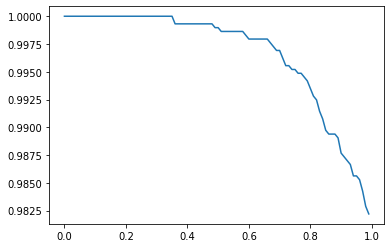

In [44]:
import matplotlib.pyplot as plt
plt.plot(threshold, probe)

In [23]:
probe

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99931554,
       0.99931554, 0.99931554, 0.99931554, 0.99931554, 0.99897331,
       0.99897331, 0.99828884, 0.99828884, 0.99828884, 0.99794661,
       0.99760438, 0.99726215, 0.99691992, 0.99691992, 0.99657769,
       0.99486653, 0.9945243 , 0.99315537, 0.99212868, 0.99075975,
       0.99075975, 0.99007529, 0.98973306, 0.9890486 , 0.9890486 ,
       0.98870637, 0.98836413, 0.98733744, 0.98631075, 0.98631

In [ ]:
results

In [39]:
threshold = 0.13 # 0.20 de iyi
LABELS = ["Normal", "Probing"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
#plt.figure(figsize=(12, 12))
#sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
#plt.title("Confusion matrix")
#plt.ylabel('True class')
#plt.xlabel('Predicted class')
#plt.show()
conf_matrix

array([[36569,  5267],
       [    0,  2922]])

In [40]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

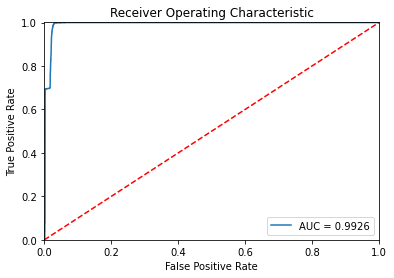

In [41]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

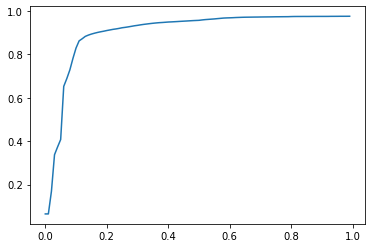

In [45]:
plt.plot(threshold, results)

Let's try if we can find a better threshold value between 0.14 and 0.18.

In [ ]:
threshold = np.arange(0.3, 0.5, 0.001)
results = np.zeros(200)
probe = np.zeros(200)
i = 0
for t in threshold:
  y_pred = [1 if e > t else 0 for e in error_df.reconstruction_error.values]
  conf_matrix = confusion_matrix(error_df.true_class, y_pred)
  results[i] = (conf_matrix[0,0] + conf_matrix[1,1]) / 44758
  probe[i] = conf_matrix[1,1] / 2922
  i = i + 1

In [ ]:
threshold

array([0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308,
       0.309, 0.31 , 0.311, 0.312, 0.313, 0.314, 0.315, 0.316, 0.317,
       0.318, 0.319, 0.32 , 0.321, 0.322, 0.323, 0.324, 0.325, 0.326,
       0.327, 0.328, 0.329, 0.33 , 0.331, 0.332, 0.333, 0.334, 0.335,
       0.336, 0.337, 0.338, 0.339, 0.34 , 0.341, 0.342, 0.343, 0.344,
       0.345, 0.346, 0.347, 0.348, 0.349, 0.35 , 0.351, 0.352, 0.353,
       0.354, 0.355, 0.356, 0.357, 0.358, 0.359, 0.36 , 0.361, 0.362,
       0.363, 0.364, 0.365, 0.366, 0.367, 0.368, 0.369, 0.37 , 0.371,
       0.372, 0.373, 0.374, 0.375, 0.376, 0.377, 0.378, 0.379, 0.38 ,
       0.381, 0.382, 0.383, 0.384, 0.385, 0.386, 0.387, 0.388, 0.389,
       0.39 , 0.391, 0.392, 0.393, 0.394, 0.395, 0.396, 0.397, 0.398,
       0.399, 0.4  , 0.401, 0.402, 0.403, 0.404, 0.405, 0.406, 0.407,
       0.408, 0.409, 0.41 , 0.411, 0.412, 0.413, 0.414, 0.415, 0.416,
       0.417, 0.418, 0.419, 0.42 , 0.421, 0.422, 0.423, 0.424, 0.425,
       0.426, 0.427,

In [ ]:
probe

array([0.99897331, 0.99897331, 0.99897331, 0.99897331, 0.99897331,
       0.99897331, 0.99897331, 0.99897331, 0.99897331, 0.99897331,
       0.99897331, 0.99897331, 0.99897331, 0.99897331, 0.99897331,
       0.99897331, 0.99897331, 0.99897331, 0.99897331, 0.99897331,
       0.99897331, 0.99897331, 0.99897331, 0.99897331, 0.99897331,
       0.99897331, 0.99897331, 0.99897331, 0.99897331, 0.99897331,
       0.99897331, 0.99897331, 0.99897331, 0.99897331, 0.99897331,
       0.99897331, 0.99897331, 0.99897331, 0.99897331, 0.99897331,
       0.99897331, 0.99897331, 0.99897331, 0.99897331, 0.99897331,
       0.99897331, 0.99897331, 0.99897331, 0.99897331, 0.99897331,
       0.99897331, 0.99897331, 0.99897331, 0.99897331, 0.99897331,
       0.99897331, 0.99897331, 0.99897331, 0.99897331, 0.99897331,
       0.99897331, 0.99897331, 0.99897331, 0.99897331, 0.99897331,
       0.99897331, 0.99828884, 0.99828884, 0.99828884, 0.99828884,
       0.99828884, 0.99828884, 0.99828884, 0.99828884, 0.99828

In [ ]:
results

array([0.95732606, 0.95759417, 0.95779525, 0.95790697, 0.95810805,
       0.95819742, 0.9583985 , 0.9585549 , 0.95873363, 0.95893472,
       0.95902409, 0.95920282, 0.95931454, 0.9595603 , 0.95976138,
       0.95998481, 0.96023057, 0.96027526, 0.96054337, 0.96076679,
       0.96085616, 0.9610349 , 0.96121364, 0.96141472, 0.96166049,
       0.96183922, 0.96208499, 0.9621967 , 0.96237544, 0.96257652,
       0.96273292, 0.96286697, 0.96297869, 0.96329148, 0.96340319,
       0.96369364, 0.96385004, 0.96405112, 0.96422986, 0.96443094,
       0.96460968, 0.96496716, 0.96525761, 0.96548103, 0.96559274,
       0.96581617, 0.96599491, 0.96617364, 0.96633004, 0.9664641 ,
       0.96659815, 0.96670986, 0.96677689, 0.96693329, 0.967045  ,
       0.96720139, 0.96731311, 0.96749185, 0.96758121, 0.96771527,
       0.96780464, 0.96789401, 0.9680504 , 0.96827383, 0.96831851,
       0.96838554, 0.96851959, 0.96858662, 0.96863131, 0.9687877 ,
       0.96896644, 0.96903347, 0.96914518, 0.96930158, 0.96936

Let's fix our threshold value to 0.499 and apply it to Validation Set.

In [ ]:
X_valid = kdd_valid_probe
y_valid = X_valid['Type_Groups']
X_valid = X_valid.drop(['Type_Groups'], axis=1)
X_valid = X_valid.values

In [ ]:
predictions = autoencoder_corr.predict(X_valid)
mse = np.mean(np.power(X_valid - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_valid})
error_df.describe()

,reconstruction_error,true_class
count,20000.000000,20000.000000
mean,0.553160,0.062200
std,19.441038,0.241524
min,0.019957,0.000000
25%,0.041338,0.000000
50%,0.086328,0.000000
75%,0.131369,0.000000
max,1940.447577,1.000000


In [ ]:
threshold = 0.499 # 0.20 de iyi
LABELS = ["Normal", "Probing"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
conf_matrix

array([[18290,   466],
       [   94,  1150]])

## XGBoosting

In [46]:
from numpy import loadtxt
from sklearn.metrics import accuracy_score
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import time

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [47]:
kdd_train_probe.head()

,Duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_error_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Type_Groups
0,-0.150103,-0.004917,0.019931,0,0,-0.005644,-0.073472,-0.021473,0.666223,-0.007208,-0.023163,-0.010262,-0.012379,-0.024657,-0.021773,-0.060732,0,0,-0.081998,-0.112107,-0.125503,-0.093846,-0.078612,-0.291137,-0.290134,0.198961,-0.201086,-0.478157,-1.336229,-1.990255,0.536542,-0.34644,-0.154032,-0.365965,-0.106951,-0.072524,-0.301727,-0.29675,0
1,-0.150103,-0.004890,-0.048616,0,0,-0.005644,-0.073472,-0.021473,0.666223,-0.007208,-0.023163,-0.010262,-0.012379,-0.024657,-0.021773,-0.060732,0,0,-0.081998,-0.112107,-0.125503,-0.093846,-0.078612,-0.291137,-0.290134,0.198961,-0.201086,-0.478157,-1.240464,-1.882796,0.536542,-0.34644,-0.346801,-0.365965,-0.106951,-0.072524,-0.301727,-0.29675,0
2,-0.150103,-0.004892,-0.036865,0,0,-0.005644,-0.073472,-0.021473,0.666223,-0.007208,-0.023163,-0.010262,-0.012379,-0.024657,-0.021773,-0.060732,0,0,-0.081998,-0.112107,-0.125503,-0.093846,-0.078612,-0.291137,-0.290134,0.198961,-0.201086,-0.478157,-1.144700,-1.775337,0.536542,-0.34644,-0.411057,-0.365965,-0.106951,-0.072524,-0.301727,-0.29675,0
3,-0.150103,-0.004899,-0.036865,0,0,-0.005644,-0.073472,-0.021473,0.666223,-0.007208,-0.023163,-0.010262,-0.012379,-0.024657,-0.021773,-0.060732,0,0,-0.081998,-0.145850,-0.218540,-0.093846,-0.078612,-0.291137,-0.290134,0.198961,-0.201086,-0.478157,-1.048936,-1.667879,0.536542,-0.34644,-0.411057,-0.365965,-0.106951,-0.072524,-0.301727,-0.29675,0
4,-0.150103,-0.004900,-0.027268,0,0,-0.005644,-0.073472,-0.021473,0.666223,-0.007208,-0.023163,-0.010262,-0.012379,-0.024657,-0.021773,-0.060732,0,0,-0.081998,-0.145850,-0.218540,-0.093846,-0.078612,-0.291137,-0.290134,0.198961,-0.201086,-0.478157,-0.953172,-1.560420,0.536542,-0.34644,-0.443185,-0.365965,-0.106951,-0.072524,-0.301727,-0.29675,0


In [48]:
def xgb_classifier(X_train, X_test, y_train, y_test, useTrainCV=True, cv_folds=5, 
                   early_stopping_rounds=50):
    """
    # {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3} 0.862920874517388
    # {'colsample_bytree': 1.0, 'gamma': 0.2} 0.871
    # {'gamma': 0.2, 'scale_pos_weight': 1} 0.8702009952422571
    # {'subsample': 0.6} 0.864310306628855
    """
    alg = XGBClassifier(learning_rate=0.1, 
                        n_estimators=140, 
                        max_depth=5, # maximum number of features used in each tree
                        min_child_weight=3, 
                        gamma=0.2, 
                        subsample=0.6, #hich is for each tree the % of rows taken to build the tree. 
                                        #I recommend not taking out too many rows, as performance will drop a lot. Take values from 0.8 to 1.
                        colsample_bytree=0.6, # number of columns used by each tree. 
                        #In order to avoid some columns to take too much credit for the prediction 
                        #(think of it like in recommender systems when you recommend the most purchased products
                        #and forget about the long tail), take out a good proportion of columns. 
                        #Values from 0.3 to 0.8 if you have many columns (especially if you did one-hot encoding), 
                        #or 0.8 to 1 if you only have a few columns.
                        objective='binary:logistic', 
                        nthread=4, 
                        scale_pos_weight=20, 
                        seed=27)

    if useTrainCV:
        print("Start Feeding Data")
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        # xgtest = xgb.DMatrix(X_test.values, label=y_test.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    print('Start Training')
    alg.fit(X_train, y_train, eval_metric='auc')

    # param_test1 = {}
    # gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
    #                                                 min_child_weight=3, gamma=0.2, subsample=0.8,
    #                                                 colsample_bytree=1.0,
    #                                                 objective='binary:logistic', nthread=4, scale_pos_weight=1,
    #                                                 seed=27),
    #                         param_grid=param_test1,
    #                         scoring='f1',
    #                         n_jobs=4, iid=False, cv=5)
    # gsearch1.fit(X_train, y_train)
    # print(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)

    print("Start Predicting")
    predictions = alg.predict(X_test)
    pred_proba = alg.predict_proba(X_test)[:, 1]

    print("\nResulting Metrics")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
    print("AUC : %f" % metrics.roc_auc_score(y_test, pred_proba))
    print("F1 Score : %f" % metrics.f1_score(y_test, predictions))

    feat_imp = alg.feature_importances_
    feat = X_train.columns.tolist()
    # clf.best_estimator_.booster().get_fscore()
    res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
    res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    print(res_df)
    print(res_df["Features"].tolist())
    return alg


In [49]:
y_train = kdd_train_probe['Type_Groups']

In [50]:
X_train = kdd_train_probe.drop(['Type_Groups'], axis = 1)

In [51]:
y_test = kdd_test_probe['Type_Groups']
X_test = kdd_test_probe.drop(['Type_Groups'], axis = 1)

Start Feeding Data
Start Training
Start Predicting

Resulting Metrics
Accuracy : 0.9622
AUC : 0.985972
F1 Score : 0.745770


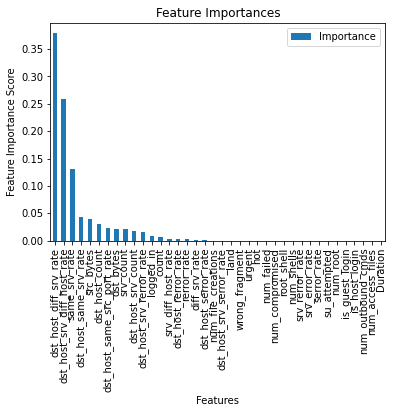

                       Features  Importance
31       dst_host_diff_srv_rate    0.378640
33  dst_host_srv_diff_host_rate    0.257967
25                same_srv_rate    0.130783
30       dst_host_same_srv_rate    0.043607
1                     src_bytes    0.039829
28               dst_host_count    0.030115
32  dst_host_same_src_port_rate    0.022549
2                     dst_bytes    0.020976
20                    srv_count    0.020545
29           dst_host_srv_count    0.017389
37     dst_host_srv_rerror_rate    0.015460
8                     logged_in    0.008047
19                        count    0.005843
27           srv_diff_host_rate    0.002685
36         dst_host_rerror_rate    0.002516
23                  rerror_rate    0.002228
26                diff_srv_rate    0.000606
34         dst_host_serror_rate    0.000214
13           num_file_creations    0.000000
35     dst_host_srv_serror_rate    0.000000
3                          land    0.000000
4                wrong_fragment 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=140, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.6, verbosity=1)

In [52]:
xgb_classifier(X_train, X_test, y_train, y_test)

## CatBoost

CatBoost is another boosting algorithm created by Yandex. It has unique way of handling with categorical variables. It is shown that CatBoost performs extremely well with its default parameters. We can optimize the hyperparameters using cross validation, random search, grid search or Bayesian Optimization.

In [53]:
!pip install catboost

     |████████████████████████████████| 65.8MB 61kB/s 


In [54]:
from catboost import Pool, CatBoostClassifier, cv

In [55]:
#model = CatBoostClassifier(eval_metric='Accuracy',use_best_model=True,random_seed=42)
model = CatBoostClassifier(eval_metric='Accuracy',random_seed=42)

#now just to make the model to fit the data
model.fit(X_train,y_train,eval_set=(X_test,y_test))

Learning rate set to 0.099171
0:	learn: 0.9945455	test: 0.9879708	best: 0.9879708 (0)	total: 97ms	remaining: 1m 36s
1:	learn: 0.9953248	test: 0.9745055	best: 0.9879708 (0)	total: 150ms	remaining: 1m 15s
2:	learn: 0.9964689	test: 0.9746136	best: 0.9879708 (0)	total: 199ms	remaining: 1m 6s
3:	learn: 0.9967549	test: 0.9745672	best: 0.9879708 (0)	total: 242ms	remaining: 1m
4:	learn: 0.9970311	test: 0.9789991	best: 0.9879708 (0)	total: 285ms	remaining: 56.6s
5:	learn: 0.9991024	test: 0.9795086	best: 0.9879708 (0)	total: 327ms	remaining: 54.1s
6:	learn: 0.9991813	test: 0.9782733	best: 0.9879708 (0)	total: 369ms	remaining: 52.3s
7:	learn: 0.9992109	test: 0.9771152	best: 0.9879708 (0)	total: 418ms	remaining: 51.8s
8:	learn: 0.9992405	test: 0.9762813	best: 0.9879708 (0)	total: 462ms	remaining: 50.8s
9:	learn: 0.9992800	test: 0.9740885	best: 0.9879708 (0)	total: 504ms	remaining: 49.9s
10:	learn: 0.9992898	test: 0.9725907	best: 0.9879708 (0)	total: 546ms	remaining: 49.1s
11:	learn: 0.9993194	test

In [56]:
print("Start Predicting")
predictions = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]

print("\nResulting Metrics")
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print("AUC : %f" % metrics.roc_auc_score(y_test, pred_proba))
print("F1 Score : %f" % metrics.f1_score(y_test, predictions))

Start Predicting

Resulting Metrics
Accuracy : 0.988
AUC : 0.982139
F1 Score : 0.902759


## Hyperparameter Optimization

We will apply RandomSearch and Bayesian Optimization to tune the hyperparameters. Since it is a time consuming process, we only show how to use the libraries for hyperparameter optimization task. For this reason, it is unlikely to beat the performance obtained by default parameters using RandomSearch or GridSearch. 

However, we can obtain better model if we use Bayesian Optimization.

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt  

parameters = {'depth'         : sp_randInt(1, 10),
              'learning_rate' : sp_randFloat(),
              'iterations'    : sp_randInt(10, 100)
}
    
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, 
                               cv = 2, n_iter = 10, n_jobs=-1)
randm.fit(X_train, y_train, eval_set=(X_test,y_test))

0:	learn: 0.9979583	test: 0.8967093	best: 0.8967093 (0)	total: 61.2ms	remaining: 3.79s
1:	learn: 0.9967056	test: 0.9689618	best: 0.9689618 (1)	total: 127ms	remaining: 3.87s
2:	learn: 0.9964196	test: 0.9769453	best: 0.9769453 (2)	total: 180ms	remaining: 3.6s
3:	learn: 0.9985501	test: 0.9830603	best: 0.9830603 (3)	total: 236ms	remaining: 3.48s
4:	learn: 0.9982739	test: 0.9847280	best: 0.9847280 (4)	total: 294ms	remaining: 3.42s
5:	learn: 0.9965281	test: 0.9857626	best: 0.9857626 (5)	total: 348ms	remaining: 3.3s
6:	learn: 0.9966662	test: 0.9865038	best: 0.9865038 (6)	total: 395ms	remaining: 3.16s
7:	learn: 0.9968733	test: 0.9858552	best: 0.9865038 (6)	total: 452ms	remaining: 3.11s
8:	learn: 0.9967254	test: 0.9873377	best: 0.9873377 (8)	total: 511ms	remaining: 3.07s
9:	learn: 0.9970410	test: 0.9890980	best: 0.9890980 (9)	total: 569ms	remaining: 3.02s
10:	learn: 0.9970410	test: 0.9892216	best: 0.9892216 (10)	total: 626ms	remaining: 2.96s
11:	learn: 0.9989446	test: 0.9892061	best: 0.9892216 

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fbd1447edd8>,
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbd144526d8>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbd14452dd8>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbd14452860>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [58]:
randm.best_estimator_

In [59]:
randm.best_params_

{'depth': 8, 'iterations': 63, 'learning_rate': 0.017860792872981812}

In [60]:
print("Start Predicting")
predictions = randm.best_estimator_.predict(X_test)
pred_proba = randm.best_estimator_.predict_proba(X_test)[:, 1]

print("\nResulting Metrics")
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print("AUC : %f" % metrics.roc_auc_score(y_test, pred_proba))
print("F1 Score : %f" % metrics.f1_score(y_test, predictions))

Start Predicting

Resulting Metrics
Accuracy : 0.9892
AUC : 0.997010
F1 Score : 0.916126


In [61]:
!pip install scikit-optimize

     |████████████████████████████████| 102kB 6.0MB/s 


In [62]:
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

In [64]:
# Converting average precision score into a scorer suitable for model selection
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

# Defining your search space
search_spaces = {'iterations': Integer(10, 300),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 #'random_strength': Real(1e-9, 10, 'log-uniform'),
                 #'bagging_temperature': Real(0.0, 1.0),
                 #'border_count': Integer(1, 255),
                 #'l2_leaf_reg': Integer(2, 30),
                 #'scale_pos_weight':Real(0.01, 1.0, 'uniform')
                 }
# Setting up BayesSearchCV
opt = BayesSearchCV(model,
                    search_spaces,
                    scoring=roc_auc,
                    n_iter=2,
                    n_jobs=-1,  
                    return_train_score=False,
                    refit=True, #use best model
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)
# Running the optimization
opt.fit(X_train, y_train)

0:	learn: 0.9974552	total: 48.9ms	remaining: 13s
1:	learn: 0.9986684	total: 95ms	remaining: 12.5s
2:	learn: 0.9984909	total: 139ms	remaining: 12.2s
3:	learn: 0.9976032	total: 182ms	remaining: 11.9s
4:	learn: 0.9979879	total: 226ms	remaining: 11.8s
5:	learn: 0.9982640	total: 276ms	remaining: 12s
6:	learn: 0.9982246	total: 320ms	remaining: 11.8s
7:	learn: 0.9983331	total: 365ms	remaining: 11.8s
8:	learn: 0.9988361	total: 410ms	remaining: 11.7s
9:	learn: 0.9984712	total: 454ms	remaining: 11.6s
10:	learn: 0.9986684	total: 502ms	remaining: 11.6s
11:	learn: 0.9992405	total: 547ms	remaining: 11.6s
12:	learn: 0.9993786	total: 599ms	remaining: 11.7s
13:	learn: 0.9994082	total: 647ms	remaining: 11.7s
14:	learn: 0.9993983	total: 693ms	remaining: 11.6s
15:	learn: 0.9993786	total: 742ms	remaining: 11.6s
16:	learn: 0.9993885	total: 788ms	remaining: 11.5s
17:	learn: 0.9993786	total: 834ms	remaining: 11.5s
18:	learn: 0.9994181	total: 880ms	remaining: 11.4s
19:	learn: 0.9994181	total: 930ms	remaining: 

BayesSearchCV(cv=None, error_score='raise',
              estimator=<catboost.core.CatBoostClassifier object at 0x7fbd1447edd8>,
              fit_params=None, iid=True, n_iter=2, n_jobs=-1, n_points=1,
              optimizer_kwargs={'base_estimator': 'GP'},
              pre_dispatch='2*n_jobs', random_state=42, refit=True,
              return_train_score=False,
              scoring=make_scorer(roc_auc_score, needs_threshold=True),
              search_spaces={'depth': Integer(low=1, high=8, prior='uniform', transform='identity'),
                             'iterations': Integer(low=10, high=300, prior='uniform', transform='identity'),
                             'learning_rate': Real(low=0.01, high=1.0, prior='log-uniform', transform='identity')},
              verbose=0)

In [65]:
print("Start Predicting")
predictions = opt.best_estimator_.predict(X_test)
pred_proba = opt.best_estimator_.predict_proba(X_test)[:, 1]

print("\nResulting Metrics")
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print("AUC : %f" % metrics.roc_auc_score(y_test, pred_proba))
print("F1 Score : %f" % metrics.f1_score(y_test, predictions))

Start Predicting

Resulting Metrics
Accuracy : 0.9559
AUC : 0.989242
F1 Score : 0.714186


## TabNet

In [2]:
!pip install pytorch_tabnet

In [68]:
from pytorch_tabnet.tab_model import TabNetClassifier

classifier = TabNetClassifier()
classifier.fit(X_train=X_train, y_train=y_train)

#predictions = classifier.predict_proba(X_test)[:,1]

Device used : cpu
No early stopping will be performed, last training weights will be used.


KeyError: ignored